In [59]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from matplotlib import pyplot as plt
import numpy as np
from vortexpanel import VortexPanel as vp
from vortexpanel import BoundaryLayer as bl

# Coefficient of Lift $C_L$

To compute the pressure, $P$, we can use the Bernoulli equation

$$ P+\frac 12 \rho\ |u|^2-\rho gz = B $$

where $\rho$ is the density, $\rho gz$ is the head, and $B$ is the Bernoulli coefficient. As in the rest of this course, will assume no hydrostatic pressure.

To avoid the ambiguity of the Bernoulli coefficient, we typically work with the pressure coefficient $c_p$

$$c_p = \frac{P-P_\infty}{\frac 12\rho\ U^2}$$
instead of the pressure.

Once we have the surface pressure we can use it to determine the pressure force on the body, as

$$ \vec F_p = -\oint p \hat n da $$

where $\oint da$ is the integral over the body surface, and $\hat n$ is the normal vector to the surface. 

For instance, the lift coefficient is then:

$$ C_L = \frac{\vec F_p \cdot \hat U_\perp} { \tfrac 12 \rho U^2 A }  = \frac{-\oint p \hat n \cdot \hat U_\perp ds }{ \tfrac 12 \rho U^2 c } c= -\frac{\oint c_p (s_x\cos\alpha+s_y\sin\alpha) ds}{ c } $$

where $c$ is the coord, $\hat U_\perp=\cos\alpha\hat y-\sin\alpha\hat x$ is the direction perpendicular to the free stream and $\hat n=s_x\hat y-s_y\hat x$.

And we can use $|u/U|^2=\tilde\gamma^2=\gamma^2$ on the body of $N$ panels to give

$$ C_L = \Sigma_N [(1-\gamma^2) S_N \hat n_N] / c $$


In [60]:
@np.vectorize
def C_L(panels,alpha):
    """ Calculate the coefficient of lift for a solved Panel Array

    Inputs:
    panels    -- a solved Panel Array
    alpha     -- the angle of attack

    Outputs:
    The coefficient of lift

    Example:
    alpha=np.radians(10)                                # set the angle of attack
    ellipse = vp.make_ellipse(N=32,t_c=0.5)             # make a 1:2 elliptical Panel array
    ellipse.solve_gamma_O2(alpha=alpha)                 # solve the ellipse flow using a second order panel array method
    print(C_L(ellipse, alpha=alpha))                    # print the coefficient of lift
    """
    panels.solve_gamma_O2(alpha, kutta=[(0,-1)])
    gamma, xc, S, sx, sy = panels.get_array('gamma','xc','S','sx','sy') # use the solved flow to retrieve gamma, xc, S, sx, sy
    c = max(xc)-min(xc)                                                 # calculate the length of the foil chord
    perp = sx*np.cos(alpha)+sy*np.sin(alpha)                            # calculate the normal 
    return -sum((1-gamma**2)*2*S*perp)/c                                # return the coefficient of lift (summation of c_p x normal over the surface)

## Validation of $C_L$ function

There exists an analytical solution for $C_L$ of a Joukowski foil

$$C_L = 2\pi \left(1+\frac 4{3\sqrt 3} \frac tc \right)\sin\alpha$$

where $t/c$ is the thickness to coord ratio.

Writing this into a simple function for testing





In [61]:
def analytic_C_L(alpha,t_c=0.2355): # t/c of jfoil xcen=-0.1
    return 2*np.pi*(1+t_c*4/(3*np.sqrt(3)))*np.sin(alpha)

Testing this on a Joukowski foil with centre (-0.1, 0) and thus $t/c = 0.2355$ leads to:

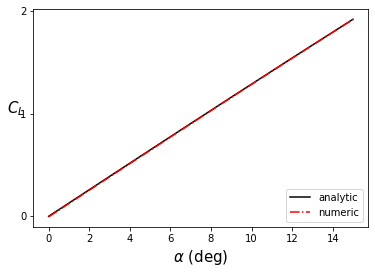

In [118]:
alpha_deg = np.linspace(0,15,6)
alpha = alpha_deg*np.pi/180.
plt.plot(alpha_deg,analytic_C_L(alpha), 'k', label='analytic')

jfoil = vp.make_jfoil(N=64, xcen=-0.1, ycen=0)
plt.plot(alpha_deg, C_L(jfoil, alpha), 'r-.', label='numeric')

plt.legend(loc='lower right')
plt.xlabel(r'$\alpha$ (deg)', fontsize=15)
plt.ylabel(r'$C_L$', fontsize=15, rotation=0)
plt.yticks([0,1,2]);

It can be seen from the above plot that there is no noticable difference between the analytical and numerical solution

# Coefficient of Drag $C_D$

Because potential flow has no pressure drag. D'Alemberts paradox states that any 'closed' flow can't give any pressure drag. Therefore we must define a wake model to measure drag

## Assumptions

* The boundary layers separate from the body into a pair of **shear layers**, 
* The shear layers maintain the same strength ($\gamma$) as they were at the point of separation. 
* The distance between the shear layers ($w$) stays the same.

The vortex impulse drag for this model is:

$$D_P = \rho \frac{d}{dt} \int_S y \gamma ds$$

given the above assumptions we have

$$ y = \pm \frac{w}{2} \text{ and } \gamma = \pm\gamma_{wake} $$

Since the wake sheets are formed from the sperating of boundary layers, the wake strength should match the potential flow solution at the point of separation

$$ \gamma_{wake} \approx u_e|_{sep} $$

and by the same argument, 

$$ \frac{d}{dt}S \text{~} u_e|_{sep} \approx \gamma_{wake}$$

since $y = +/- 0.5w$ and $ds/dt \approx \gamma$, we have

$$D_P \tilde{} \rho \gamma^2 A_w$$

where $A_w = wh$ is the wake width

$$C_D = \frac{D}{0.5 \rho U^2 A_F} \propto \frac{A_w \gamma^2}{A_F U^2} \equiv A_\gamma$$

Therefore we define a wake drag coefficient as:

$$C_\gamma = \frac{wb}{A_F} \tilde{u}^2_e|_{sep} = \frac {\rho \gamma^2 w}{\rho U^2 t} = \frac w t \tilde\gamma ^2 \propto C_P$$ 

Since the wake coefficient $C_\gamma$ only scales like the drag coeffient $C_D$ we must calibrate our wake drag coefficient $C_\gamma$ to scale with $C_D$ using empirical data from Hoerner for an ellipse at 0 angle of attack:

```
c_t = [1.27,1.67,2.06,3.06,3.39,4.03,4.73,8.15]
CD = [0.919,0.718,0.604,0.438,0.408,0.342,0.324,0.267]
```

where `c_t` is the $c/t$ value of the ellipse, and `CD` is the $C_D$ value measure in the experiments



In [68]:
def C_gamma(panels):
    top,bot=panels.split()                              # split the panels at the stagnation point
    _,_,iSep = top.thwaites()                           # locate the separation point along the top of the shape
    gamma_top = bl.sep(top.get_array('gamma'),iSep)     # get the value of gamma at the separation point
    w_top = bl.sep(top.get_array('yc'),iSep)            # get the y-value (measured perpendicularly from the chord) at the separation point (w)
    y = panels.get_array('yc')                          # get the y-values of the panel array
    thickness = max(y)-min(y)                           # calculate the height of the shape (t)
    return (2*w_top*gamma_top**2)/thickness             # calcualte the wake coefficient

Calibrating the function using `numpy.polyfit` and `numpy.poly1D` to fit a first-order line through the points, forcing an point at the origin since $C_\gamma \propto C_D$ we know that when $C_D = 0$, $C_\gamma$ will also equal $0$:

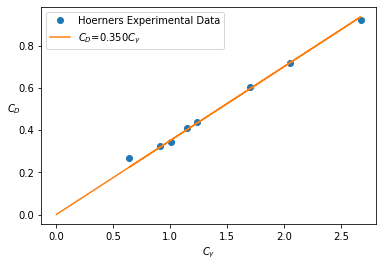

In [114]:
# Hoerner's data
c_t = np.array([1.27,1.67,2.06,3.06,3.39,4.03,4.73,8.15])
CD = [0.919,0.718,0.604,0.438,0.408,0.342,0.324,0.267]

@np.vectorize
def ellipse_c_gamma(t_c, N=64):
    panels = vp.make_ellipse(N, t_c)    # create a PanelArray object for an ellipse
    panels.solve_gamma_O2()             # solve the flow
    return C_gamma(panels)              # return the value of C_gamma

plt.plot(ellipse_c_gamma(1/c_t), CD, 'o', label=r'Hoerners Experimental Data')  # plot the wake ceofficient against the experimental data

x = np.append(np.array([0]), ellipse_c_gamma(1/c_t), axis=0)    # setup the data with a point at the origin
y = np.append(np.array([0]), CD, axis=0)
weights= np.append(np.array([10**10]), np.ones_like(CD))        # weight the point at the origin high to force the regression through that point
best_fit=np.polyfit(x, y, 1, w=weights)                         # regress the weighted data
plt.plot(x, np.poly1d(best_fit)(x), label=r'$C_D$={:.3f}$C_\gamma$'.format(best_fit[0]))    # plot the data

plt.xlabel(r'$C_\gamma$')
plt.ylabel(r'$C_D$', rotation=0)
plt.legend()
plt.show();